In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Data/creditcard_csv.csv')
data.Class.replace(["'0'","'1'"],[0,1],inplace=True)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.Class.value_counts() #Label counts

0    284315
1       492
Name: Class, dtype: int64

In [4]:
data.isna().values.any() #Check if any NaN value

False

In [5]:
def sample_normalize_dataset(df, label):
    #df_y = df.pop(label)
    #df_x = (df-df.mean())/df.std()
    np.random.seed(2)
    test_indices = np.zeros(52092)
    class_1_indices = df[df.Class==1].index.values
    test_indices[:92] = np.random.choice(class_1_indices,size=92, replace=False)
    class_0_indices = df[df.Class==0].index.values
    test_indices[92:] = np.random.choice(class_0_indices,size=52000, replace=False)
    
    test_df = df.iloc[test_indices]
    train_df = df.drop(test_indices)
    
    train_df_y = train_df.pop(label)
    test_df_y = test_df.pop(label)
    
    mu = train_df.mean()
    std_dev = train_df.std()
    
    train_df_x = (train_df-mu)/std_dev
    test_df_x = (test_df-mu)/std_dev
    
    train_df_x.reset_index(drop=True, inplace=True),
    train_df_y.reset_index(drop=True, inplace=True)
    test_df_x.reset_index(drop=True, inplace=True) 
    test_df_y.reset_index(drop=True, inplace=True)
            
    return train_df_x, train_df_y, test_df_x, test_df_y

In [6]:
df_train_x, df_train_y, df_test_x, df_test_y = sample_normalize_dataset(data, "Class")

In [7]:
def fit_model(train_X, train_Y, test_X, test_Y, weights=None):
    auc_scores={}
    nll_scores={}
    reg_C = [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1e+00, 1e+01, 1e+02, 1e+03, 1e+04]
    for c in reg_C:
        clf = LogisticRegression(penalty = 'l2', C=c, solver='liblinear', class_weight=weights).fit(train_X, train_Y)
        predicted_Y = clf.predict_proba(test_X)
        nll_scores[c] = log_loss(test_Y, predicted_Y[:,1])
        auc_scores[c] = roc_auc_score(test_Y, clf.predict(test_X))
    return auc_scores, nll_scores

### Full dataset

In [8]:
auc_full, nll_full = fit_model(df_train_x, df_train_y, df_test_x, df_test_y)

In [9]:
c = max(auc_full, key=auc_full.get)
print('AUC:{} | NLL Loss: {}'.format(auc_full[c], nll_full[c]))

AUC:0.7933436454849497 | NLL Loss: 0.005637480726083908


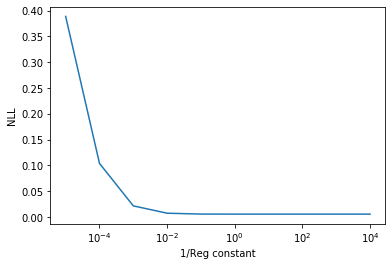

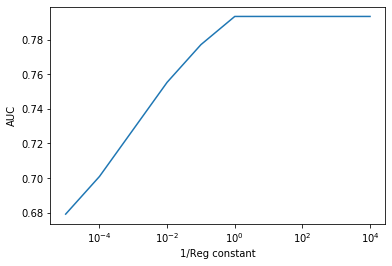

In [10]:
plt.plot(list(nll_full.keys()), list(nll_full.values()))
plt.xlabel('1/Reg constant')
plt.xscale('log')
plt.ylabel('NLL')
plt.show()
plt.plot(list(auc_full.keys()), list(auc_full.values()))
plt.xscale('log')
plt.xlabel('1/Reg constant')
plt.ylabel('AUC')
plt.show()

### Undersampling 

In [11]:
def undersample(df_X, df_Y, n_samples):
    undersampled_indices=np.zeros(n_samples+400)
    class_0_indices = df_Y[df_Y==0].index.values
    undersampled_indices[:n_samples] = np.random.choice(class_0_indices,size=n_samples, replace=False)
    undersampled_indices[n_samples:] = df_Y[df_Y==1].index.values
    undersampled_X = df_X.iloc[undersampled_indices]
    undersampled_Y = df_Y.iloc[undersampled_indices]
    undersampled_X.reset_index(drop=True, inplace=True)
    undersampled_Y.reset_index(drop=True, inplace=True)
    
    return undersampled_X,undersampled_Y 

In [12]:
def train_test_model(frac, df_train_x, df_train_y, df_test_x, df_test_y, weights=None):
    plt.figure(figsize=(12,8))
    plt.subplot(211)
    ax1 = plt.subplot(2, 1, 1)
    ax1.set_xscale('log')
    ax1.set_xlabel('1/Reg constant')
    ax1.set_ylabel('NLL')
    ax2 = plt.subplot(2, 1, 2)
    ax2.set_xscale('log')
    ax2.set_xlabel('1/Reg constant')
    ax2.set_ylabel('AUC')
    
    for f in tqdm(frac):
        auc_us_bootstrap=np.zeros((50,10))
        nll_us_bootstrap=np.zeros((50,10))
        for i in range(50):
            df_us_train_x, df_us_train_y = undersample(df_train_x, df_train_y, int(f*400))
            auc_us, nll_us = fit_model(df_us_train_x, df_us_train_y, df_test_x, df_test_y, weights)
            auc_us_bootstrap[i] = np.array(list(auc_us.values()))
            nll_us_bootstrap[i] = np.array(list(nll_us.values()))
            
        mean_auc_us = np.mean(auc_us_bootstrap, axis=0)
        std_auc_us = np.std(auc_us_bootstrap, axis=0)
        mean_nll_us = np.mean(nll_us_bootstrap, axis=0)
        std_nll_us = np.std(nll_us_bootstrap, axis=0)
        
        idx_auc = np.argsort(mean_auc_us)[-3:]
        top_3_auc_mean = mean_auc_us[idx_auc]
        top_3_auc_std = std_auc_us[idx_auc]
        top_3_nll_mean = mean_nll_us[idx_auc]
        top_3_nll_std = std_nll_us[idx_auc]
        print('For fraction {}, \n top 3 mean AUCs: {} ± {} \n and associated NLL losses: {} ± {}'.format(f, 
                                                                                                top_3_auc_mean,
                                                                                                top_3_auc_std, 
                                                                                                top_3_nll_mean,
                                                                                                top_3_nll_std))
        
        
        ax1.errorbar(list(nll_us.keys()), mean_nll_us, std_nll_us, label='Minority fraction: {}'.format(1/f))
        
        ax2.errorbar(list(auc_us.keys()), mean_auc_us, std_auc_us, label='Minority fraction: {}'.format(1/f))
        
    ax1.legend()
    ax2.legend()
    plt.show()

 33%|███▎      | 1/3 [00:18<00:37, 18.77s/it]

For fraction 1, 
 top 3 mean AUCs: [0.93106955 0.93152792 0.93414751] ± [0.00557702 0.0058075  0.00661863] 
 and associated NLL losses: [0.15808757 0.15996219 0.16533377] ± [0.03791752 0.03570218 0.03794369]


 67%|██████▋   | 2/3 [01:00<00:25, 25.80s/it]

For fraction 10, 
 top 3 mean AUCs: [0.90272836 0.90285052 0.90294441] ± [0.00402593 0.00427341 0.00414611] 
 and associated NLL losses: [0.02721097 0.02665351 0.02691113] ± [0.00450627 0.00388997 0.00415984]


100%|██████████| 3/3 [03:47<00:00, 67.90s/it]

For fraction 100, 
 top 3 mean AUCs: [0.86868266 0.86879174 0.86944622] ± [0.00825284 0.00815301 0.00809676] 
 and associated NLL losses: [0.00759483 0.00759895 0.00765175] ± [0.00037073 0.00036691 0.00033965]


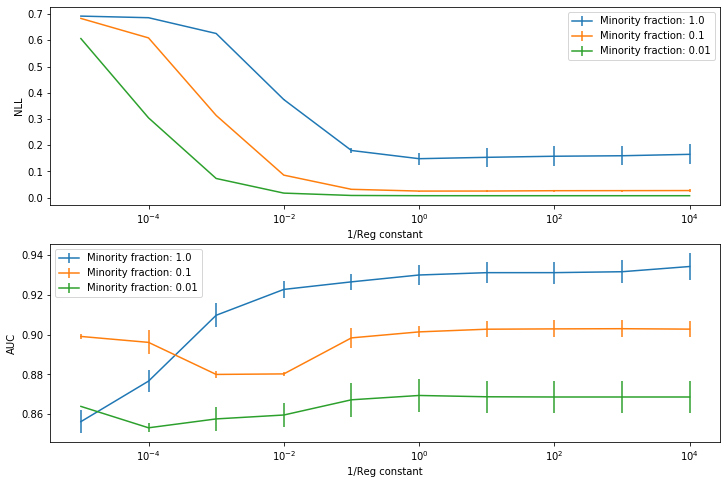

In [13]:
train_test_model([1,10,100], df_train_x, df_train_y, df_test_x, df_test_y)

### Undersampling with weighing undersampled instances to match test distribution 

 33%|███▎      | 1/3 [00:14<00:29, 14.69s/it]

For fraction 1, 
 top 3 mean AUCs: [0.88153047 0.8946638  0.89873472] ± [0.00730601 0.01107661 0.0107956 ] 
 and associated NLL losses: [0.02152222 0.04428707 0.0585047 ] ± [0.009529   0.02256295 0.02970978]


 67%|██████▋   | 2/3 [00:35<00:16, 16.53s/it]

For fraction 10, 
 top 3 mean AUCs: [0.80015147 0.81388697 0.81680349] ± [0.07861748 0.07233288 0.07069625] 
 and associated NLL losses: [0.00969022 0.01095313 0.01141746] ± [0.00177895 0.00215931 0.0024181 ]


100%|██████████| 3/3 [02:42<00:00, 49.68s/it]

For fraction 100, 
 top 3 mean AUCs: [0.62193979 0.64041632 0.64258966] ± [0.02481695 0.02570999 0.02634966] 
 and associated NLL losses: [0.00986962 0.01021307 0.01027982] ± [0.00037567 0.00035481 0.00034741]


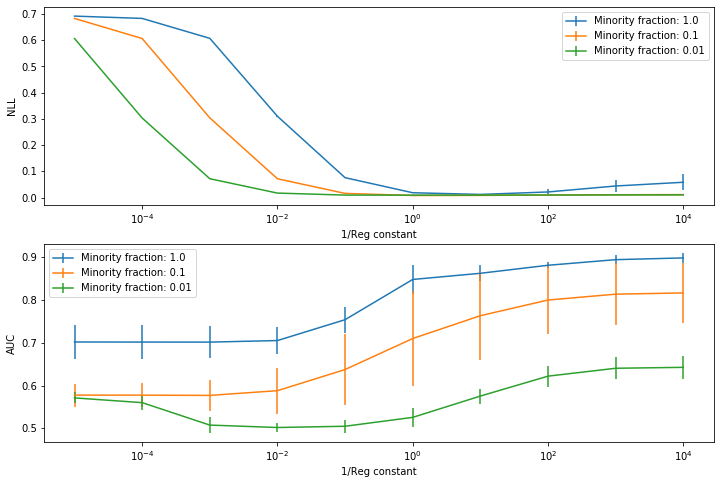

In [14]:
w = dict(data.Class.value_counts()/data.shape[0])
train_test_model([1,10,100], df_train_x, df_train_y, df_test_x, df_test_y, w)